### Import libaries

In [29]:
import gc
import sys
import os 
import numpy as np 
import pandas as pd 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, DMatrix, cv
import warnings
warnings.filterwarnings("ignore")

In [3]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [4]:
from util import *
%load_ext autoreload
%autoreload 2

### Import data and split into train and test

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.2,random_state=2020)

### garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


----
### Decision tree classifer 

* base model 

In [7]:
base_model = DecisionTreeRegressor(random_state=2020)

In [8]:
base_model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=2020)

In [9]:
regression_metrics(base_model,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.95769,2026.726437,462.969925
test,0.93004,2624.082763,462.969925


### Much better as compared to a linear regression model with elasticnet regularization. 

### Let's perform gridsearch to see if we can further improve the result

#### Key parameters:
  * max_depth: default None
  * min_samples_split: repeat of max_depth, default 2 
  * min_samples_leaf:default 1 
  * max_features: default None (n_features)

In [10]:
params = {
    "max_features":["auto",0.8,"sqrt","log2"]
}

In [11]:
searchGrid = GridSearchCV(base_model,params,scoring="r2",n_jobs=22)

In [12]:
searchGrid.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=2020), n_jobs=22,
             param_grid={'max_features': ['auto', 0.8, 'sqrt', 'log2']},
             scoring='r2')

In [13]:
searchGrid.best_params_, searchGrid.best_score_

({'max_features': 'auto'}, 0.9285933079082547)

In [14]:
regression_metrics(searchGrid.best_estimator_,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.95769,2026.726437,462.969925
test,0.93004,2624.082763,462.969925


### Let's look at feature importance

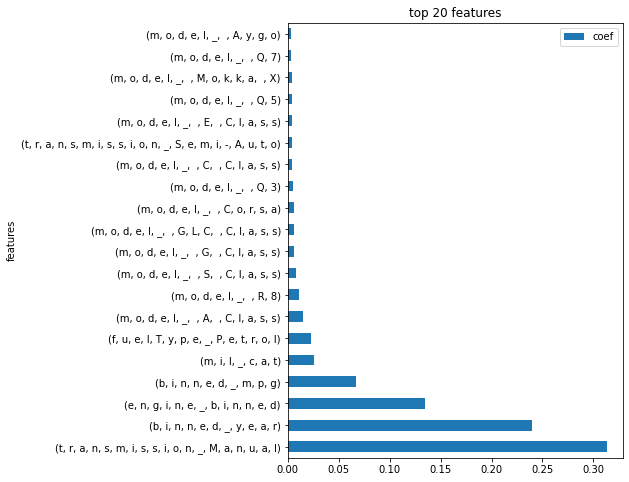

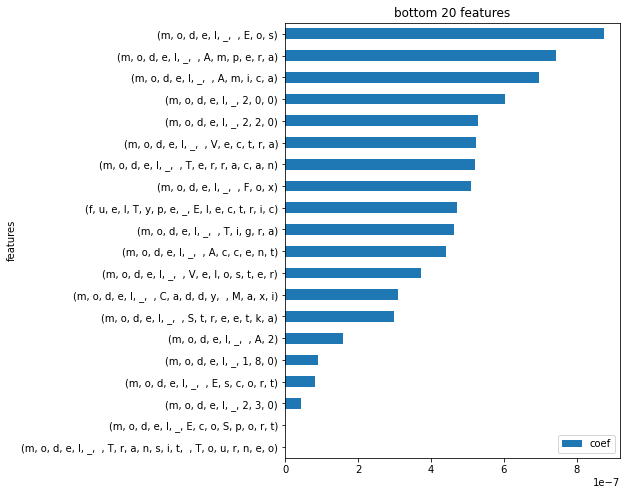

,features,score
199,"(t, r, a, n, s, m, i, s, s, i, o, n, _, M, a, ...",3.130766e-01
0,"(b, i, n, n, e, d, _, y, e, a, r)",2.397182e-01
3,"(e, n, g, i, n, e, _, b, i, n, n, e, d)",1.344734e-01
2,"(b, i, n, n, e, d, _, m, p, g)",6.668957e-02
1,"(m, i, l, _, c, a, t)",2.534020e-02
...,...,...
194,"(m, o, d, e, l, _, 1, 8, 0)",8.967238e-08
61,"(m, o, d, e, l, _, , E, s, c, o, r, t)",8.167148e-08
197,"(m, o, d, e, l, _, 2, 3, 0)",4.492542e-08
198,"(m, o, d, e, l, _, E, c, o, S, p, o, r, t)",0.000000e+00


In [15]:
linear_feature_importance(X_train,base_model,True)

### feature importance ranking is quite different from linear regression model.
### Let's look at the tree

In [16]:
text_representation = tree.export_text(base_model, feature_names=list(features.columns))
print(text_representation)

|--- transmission_Manual <= 0.50
|   |--- binned_year <= 3.50
|   |   |--- engine_binned <= 0.50
|   |   |   |--- binned_year <= 2.50
|   |   |   |   |--- binned_year <= 1.50
|   |   |   |   |   |--- model_ Q5 <= 0.50
|   |   |   |   |   |   |--- binned_mpg <= 2.50
|   |   |   |   |   |   |   |--- mil_cat <= 4.50
|   |   |   |   |   |   |   |   |--- model_ Tiguan <= 0.50
|   |   |   |   |   |   |   |   |   |--- model_ X1 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- model_ A6 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 27
|   |   |   |   |   |   |   |   |   |   |--- model_ A6 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [8995.00]
|   |   |   |   |   |   |   |   |   |--- model_ X1 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- mil_cat <= 3.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [8995.00]
|   |   |   |   |   |   |   |   |   |   |--- mil_cat >  3.50
|   |   |   |   |   |   |   |   |   |   |   |--- v

In [18]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(base_model, 
#                    feature_names=features.columns,  
#                    class_names="price",
#                    filled=True)

### Let's see if an ensemble method would improve the outcome

In [19]:
base_forest = RandomForestRegressor(random_state=2020)

In [20]:
base_forest.fit(X_train,y_train)

RandomForestRegressor(random_state=2020)

In [21]:
regression_metrics(base_forest,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.955985,2067.171534,413.433714
test,0.932764,2572.489413,413.433714


### Slightly better than decision tree. 

#### Let's tune with gridsearch

#### Key parameters:

* n_estimators: default 100 
* max_features: default auto (all feautres) sqrt, log2 
* max_samples: if boostrap is true, num of samples draw from X to train , default =None, all samples


In [22]:
params_forest = {
    "n_estimators":[100,200,300],
    "max_samples":[None,0.8]   
}

In [23]:
gridSearch_forest = GridSearchCV(base_forest,params_forest,scoring="r2",
                            n_jobs=20,verbose=True)

In [24]:
gridSearch_forest.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  22 out of  30 | elapsed:  4.0min remaining:  1.5min
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:  4.4min finished


GridSearchCV(estimator=RandomForestRegressor(random_state=2020), n_jobs=20,
             param_grid={'max_samples': [None, 0.8],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=True)

In [25]:
gridSearch_forest.best_params_, gridSearch_forest.best_score_

({'max_samples': None, 'n_estimators': 300}, 0.9311955833198)

In [26]:
regression_metrics(gridSearch_forest.best_estimator_,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.956049,2065.664094,409.106868
test,0.932715,2573.413548,409.106868


### Slightly better with more trees. 

### Let's look at feature importances

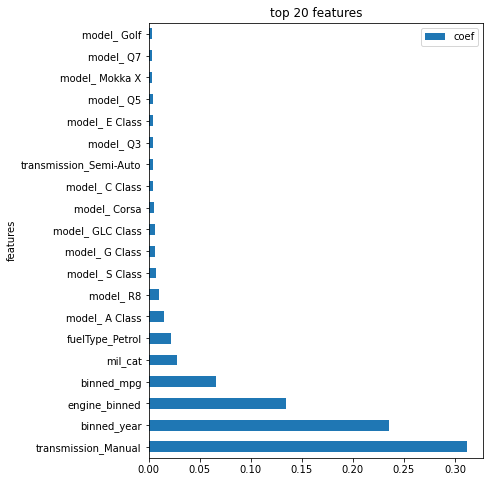

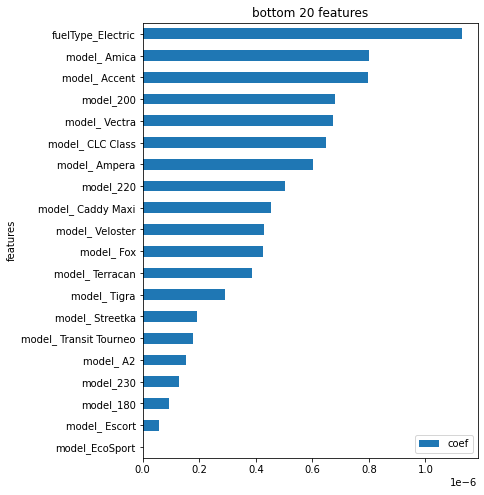

,features,score
199,transmission_Manual,3.120976e-01
0,binned_year,2.355262e-01
3,engine_binned,1.346008e-01
2,binned_mpg,6.646508e-02
1,mil_cat,2.815153e-02
...,...,...
13,model_ A2,1.516733e-07
197,model_230,1.293272e-07
194,model_180,9.345862e-08
61,model_ Escort,5.840428e-08


In [27]:
linear_feature_importance(X_test.columns,gridSearch_forest.best_estimator_,tree_model=True)

In [28]:
price_diff(gridSearch_forest.best_estimator_,features,y).sort_values("price_diff_abs",ascending=False)[:10]

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,...,model_EcoSport,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct,price_diff_abs
47201,1,5,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-472.952905,472.952905
44539,1,4,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-453.125096,453.125096
39540,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,-409.106868,409.106868
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-396.783875,396.783875
72016,1,5,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-345.244278,345.244278
87481,0,4,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,-343.074795,343.074795
71617,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-340.143739,340.143739
52100,2,5,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-265.011454,265.011454
72349,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-263.191994,263.191994
71817,1,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-255.109175,255.109175


#### Tend to over predict price on old car with high milage. 

### Top features are similar among tree and random forest. Bottom features are relatively similar as well

### Let's look at how xgboost work:

#### Turn dataframe into 

In [32]:
train_dmatrix = DMatrix(data=X_train,label=y_train)

In [33]:
XG_BASE = XGBRegressor(objective="reg:squarederror",seed=2020)

In [34]:
XG_BASE.fit(X_train,y_train,eval_metric="rmse")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2020,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [35]:
regression_metrics(XG_BASE,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.932190,2565.792938,704.150766
test,0.918903,2825.230935,704.150766


### GridSearchTuning

### Key parameters:
* learning_rate
* n_estimators
* subsample
* colsample_bytree

In [51]:
params = {
    "learning_rate":[0.25,0.5],
    "n_estimators":[150,200,250],
    "subsample":[0.9,0.8,0.7],
    "colsample_bytree":[1.0,0.9]
}

In [52]:
gridSearch_xg = GridSearchCV(estimator=XG_BASE, param_grid=params,cv=5,
                          scoring="r2",n_jobs=20,verbose=1)

In [54]:
gridSearch_xg.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 180 out of 180 | elapsed: 15.6min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=2020,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity

In [55]:
gridSearch_xg.best_params_,gridSearch_xg.best_score_

({'colsample_bytree': 1.0,
  'learning_rate': 0.5,
  'n_estimators': 250,
  'subsample': 0.9},
 0.9344731464578357)

In [56]:
regression_metrics(gridSearch_xg.best_estimator_,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.950493,2192.329270,1034.183143
test,0.933088,2566.282337,1034.183143


### Let's try to perform cv 

In [74]:
params = gridSearch_xg.best_params_
del params["n_estimators"]

In [85]:
params

{'colsample_bytree': 1.0, 'learning_rate': 0.5, 'subsample': 0.9}

In [75]:
cv_results = cv(dtrain=train_dmatrix,params=params, nfold=5,
               num_boost_round=300,early_stopping_rounds=20,
               metrics="rmse",as_pandas=True,
               seed=2020)

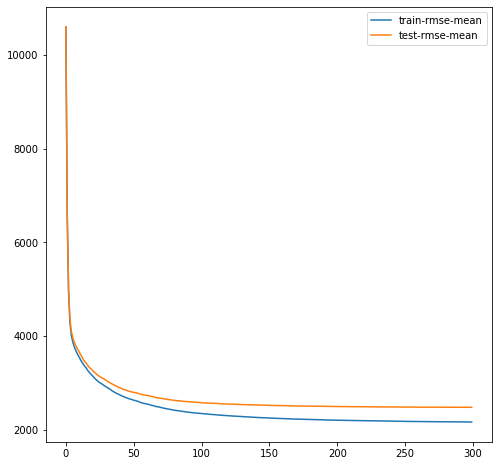

In [81]:
cv_results[["train-rmse-mean","test-rmse-mean"]].plot.line(figsize=(8,8))
plt.show()

In [83]:
cv_results.tail(1)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
299,2161.032959,11.977239,2475.894434,88.20645


In [86]:
xg_model = XGBRegressor(n_estimators=300,colsample_bytree=1.0,learning_rate=0.5,subsample=0.9)

In [87]:
xg_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
regression_metrics(xg_model,X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.951312,2174.127662,376.350759
test,0.934342,2542.121827,376.350759


### xgboost slightly outperforms random forest and decision tree. 

### Look at the features